# ELBO Equivalence & Reparameterization (with MNIST demos)

**Learning goals**

1. Define the Evidence Lower Bound (ELBO) and show its equivalence to the variational objective:
   $$
   \log p_\theta(x) \ge \mathbb{E}_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)] - \mathrm{KL}\big(q_\phi(z\mid x)\,\|\,p(z)\big) \equiv \mathcal{L}(\theta,\phi;x)
   $$
2. Derive the ELBO decomposition and show how maximizing it approximates maximum likelihood.
3. Explain and derive the **reparameterization trick** for low-variance gradient estimates:
   $$
   z = \mu_\phi(x) + \sigma_\phi(x)\odot \epsilon,\quad \epsilon\sim\mathcal{N}(0,I)
   $$
   turning $ \mathbb{E}_{q_\phi(z\mid x)}[f(z)] $ into $ \mathbb{E}_{\epsilon}[f(\mu_\phi(x)+\sigma_\phi(x)\epsilon)] $.
4. Implement a small VAE for MNIST (latent dim = 3 so we can show 2D and 3D visualizations), compute ELBO components for a batch and print step-by-step values.
5. Plot many visuals: reconstructions, latent 2D scatter, latent 3D scatter, ELBO / losses over iterations.

Follow the code cells in order. Each code cell prints intermediate values and explains what happened.


# Short derivation of the ELBO (math)

We start from the log marginal likelihood:
$$
\log p_\theta(x) = \log \int p_\theta(x,z)\,dz = \log \int \frac{p_\theta(x,z)}{q_\phi(z\mid x)} q_\phi(z\mid x)\,dz.
$$

By Jensen's inequality (or rearranging), we get:
$$
\log p_\theta(x) \ge \mathbb{E}_{q_\phi(z\mid x)}\Big[\log\frac{p_\theta(x,z)}{q_\phi(z\mid x)}\Big]
= \mathbb{E}_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)] - \mathrm{KL}\big(q_\phi(z\mid x)\,\|\,p(z)\big),
$$
which we call the ELBO:
$$
\mathcal{L}(\theta,\phi;x) = \mathbb{E}_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)] - \mathrm{KL}(q_\phi(z\mid x)\|p(z)).
$$

Maximizing $\mathcal{L}$ w.r.t. $\theta,\phi$ (equivalently minimizing $-\mathcal{L}$) both improves reconstruction likelihood and makes the approximate posterior $q_\phi(z\mid x)$ close to prior $p(z)$.  

**Reparameterization trick:** If $q_\phi(z\mid x)=\mathcal N(z;\mu_\phi(x),\mathrm{diag}(\sigma_\phi(x)^2))$, then
sample $z$ as
$$
z = \mu_\phi(x) + \sigma_\phi(x)\odot\epsilon,\quad \epsilon\sim\mathcal N(0,I),
$$
so gradients w.r.t. $\phi$ pass through $\mu_\phi$ and $\sigma_\phi$ deterministically (low-variance estimator).


In [1]:
# Python cell: imports, reproducibility and small helpers
import os, math, random, time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, utils as vutils

# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 63.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.63MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch images shape: torch.Size([128, 1, 28, 28])
Batch labels shape: torch.Size([128])
Label example: [1, 2, 8, 5, 2, 6, 9, 9]


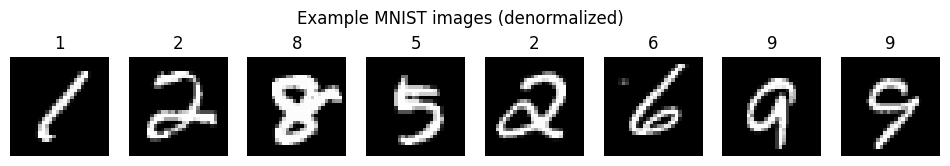

In [2]:
# Python cell: load MNIST and display a few examples
transform = transforms.Compose([
    transforms.ToTensor(),                  # [0,1]
    transforms.Normalize((0.5,), (0.5,))    # [-1,1]
])
trainset = torchvision.datasets.MNIST(root="./mnist_data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# inspect one batch
images, labels = next(iter(trainloader))
print("Batch images shape:", images.shape)  # (B,1,28,28)
print("Batch labels shape:", labels.shape)
print("Label example:", labels[:8].tolist())

# Visualize first 8
fig, axs = plt.subplots(1,8, figsize=(12,2))
for i in range(8):
    img_show = images[i].cpu().squeeze(0)*0.5 + 0.5  # denormalize to [0,1]
    axs[i].imshow(img_show, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(int(labels[i].item()))
plt.suptitle("Example MNIST images (denormalized)")
plt.show()


# VAE architecture and the ELBO components (what we will compute)

We implement a small encoder $q_\phi(z\mid x)=\mathcal N(\mu_\phi(x),\mathrm{diag}(\sigma_\phi(x)^2))$
and decoder $p_\theta(x\mid z)$ (we use Bernoulli / or Gaussian decoder; here we use Bernoulli-likelihood implemented with `BCE` on normalized pixels).

ELBO per example:
$$
\mathcal{L}(x) = \mathbb{E}_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)] - \mathrm{KL}\big(q_\phi(z\mid x)\|p(z)\big).
$$

We compute:
- $\mu_\phi(x),\ \log\sigma^2_\phi(x)$ from encoder,
- reparameterize $z = \mu_\phi(x) + \sigma_\phi(x)\odot\epsilon$,
- compute $\log p_\theta(x\mid z)$ (reconstruction log-likelihood via BCE, averaged per pixel),
- compute $\mathrm{KL}(\mathcal N(\mu,\sigma^2)\| \mathcal N(0,1))$ in closed form:
  $$
  \mathrm{KL} = -\frac{1}{2}\sum_{j=1}^d\big(1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2\big).
  $$
We will print each scalar and tensor shape so you can follow the computation.


In [3]:
# Python cell: small VAE with latent dim = 3 so we can plot 2D/3D
latent_dim = 3  # set to 3 for 2D+3D visuals

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),   # 28->14
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),  # 14->7
            nn.Flatten()
        )
        # compute flattened size
        with torch.no_grad():
            dummy = torch.zeros(1,1,28,28)
            feat = self.conv(dummy)
            self.flat_dim = feat.shape[1]
        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)
    def forward(self, x):
        h = self.conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),  # 7->14
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.ReLU(),  # 14->28
            nn.Conv2d(16, 1, 3, 1, 1),
            nn.Tanh()  # outputs in [-1,1], we will map to [0,1] for BCE-style visualization
        )
    def forward(self, z):
        h = self.fc(z).view(z.size(0), 64, 7, 7)
        x_recon = self.deconv(h)
        return x_recon

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.enc = Encoder(latent_dim)
        self.dec = Decoder(latent_dim)
    def reparameterize(self, mu, logvar):
        # reparameterization trick: z = mu + sigma * eps
        std = (0.5*logvar).exp()   # sigma = exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z, eps, std
    def forward(self, x):
        mu, logvar = self.enc(x)
        z, eps, std = self.reparameterize(mu, logvar)
        x_recon = self.dec(z)
        return x_recon, mu, logvar, z, eps, std

vae = VAE(latent_dim).to(device)
print("VAE model created. Latent dim:", latent_dim)
print("Encoder flat dim:", vae.enc.flat_dim)


VAE model created. Latent dim: 3
Encoder flat dim: 3136


In [4]:
# Python cell: compute ELBO components for one batch and print shapes/numbers step-by-step
vae.eval()
images, labels = next(iter(trainloader))
images = images.to(device)[:64]  # use 64 for clear prints
B = images.size(0)
print("Using batch size:", B)

with torch.no_grad():
    # forward pass through encoder -> mu, logvar
    mu, logvar = vae.enc(images)
    print("mu shape:", mu.shape, "logvar shape:", logvar.shape)
    print("mu (first 4 rows):\n", mu[:4].cpu().numpy())
    print("logvar (first 4 rows):\n", logvar[:4].cpu().numpy())

    # reparameterize (we also print eps and std)
    z, eps, std = vae.reparameterize(mu, logvar)
    print("z shape:", z.shape, "eps shape:", eps.shape, "std shape:", std.shape)
    print("eps (first 4 rows):\n", eps[:4].cpu().numpy())
    print("std (first 4 rows):\n", std[:4].cpu().numpy())

    # decode
    x_recon = vae.dec(z)
    print("x_recon shape (B,C,H,W):", x_recon.shape)
    # map to [0,1] for BCE-like probabilities (original images are normalized to [-1,1])
    x_recon_prob = (x_recon * 0.5) + 0.5
    images_orig = (images * 0.5) + 0.5

    # reconstruction log-likelihood approx with Bernoulli (BCE): sum over pixels per example
    bce_per_pixel = F.binary_cross_entropy_with_logits(x_recon, images, reduction='none')
    # NOTE: x_recon was Tanh output; using binary_cross_entropy_with_logits expects logits -
    # for demonstration we will compute BCE by treating x_recon_prob as probabilities:
    bce_prob = F.binary_cross_entropy(x_recon_prob.clamp(1e-6,1-1e-6), images_orig, reduction='none')
    bce_per_example = bce_prob.view(B, -1).sum(dim=1)   # sum over pixels -> negative log-likelihood (approx)
    print("BCE per example (first 6):", bce_per_example[:6].cpu().numpy())

    # KL term per example (closed form): KL(N(mu, sigma^2) || N(0,1))
    # KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_per_dim = 1 + logvar - mu.pow(2) - logvar.exp()
    kl_per_example = -0.5 * kl_per_dim.sum(dim=1)
    print("KL per example (first 6):", kl_per_example[:6].cpu().numpy())

    # ELBO per example
    elbo_per_example = - (bce_per_example + kl_per_example)   # since bce is negative log-likelihood; sign chosen to show log p lower bound
    # Note many implementations average pixelwise; here we keep sums for clarity
    print("ELBO per example (first 6):", elbo_per_example[:6].cpu().numpy())

    # print averages
    print("Average BCE (NLL) (mean over batch):", bce_per_example.mean().item())
    print("Average KL (mean over batch):", kl_per_example.mean().item())
    print("Average ELBO (mean over batch):", elbo_per_example.mean().item())


Using batch size: 64
mu shape: torch.Size([64, 3]) logvar shape: torch.Size([64, 3])
mu (first 4 rows):
 [[-0.04450765  0.10013709  0.18496934]
 [-0.02852259  0.21687685  0.13255763]
 [ 0.03939874  0.23093688  0.13400511]
 [-0.02703999  0.1644046   0.13398513]]
logvar (first 4 rows):
 [[ 0.00089515  0.06735408  0.27344197]
 [ 0.01175841 -0.03013488  0.22152434]
 [-0.01191567  0.00601447  0.1474851 ]
 [ 0.08188821  0.01445365  0.2708539 ]]
z shape: torch.Size([64, 3]) eps shape: torch.Size([64, 3]) std shape: torch.Size([64, 3])
eps (first 4 rows):
 [[-1.0801461   0.58752626  0.92462945]
 [ 1.4741018  -0.9222861  -0.08884642]
 [-0.45307827  1.9368237  -0.6500003 ]
 [-2.8901775  -1.2900509  -0.5175689 ]]
std (first 4 rows):
 [[1.0004476  1.0342505  1.1465082 ]
 [1.0058966  0.9850455  1.1171292 ]
 [0.99405986 1.0030117  1.0765296 ]
 [1.0417938  1.007253   1.1450255 ]]
x_recon shape (B,C,H,W): torch.Size([64, 1, 28, 28])
BCE per example (first 6): [579.2227  577.6192  571.68066 580.07825 5

In [5]:
# Python cell: quick training for a few epochs to get sensible reconstructions (fast)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 3  # small to be fast; increase for better reconstructions

loss_trace = {"bce": [], "kl": [], "elbo": []}
vae.train()
for epoch in range(num_epochs):
    epoch_bce = []
    epoch_kl = []
    for i, (imgs, _) in enumerate(trainloader):
        imgs = imgs.to(device)
        B = imgs.size(0)
        x_recon, mu, logvar, z, eps, std = vae(imgs)
        x_recon_prob = (x_recon * 0.5) + 0.5
        # per-example NLL (sum over pixels)
        bce_per_example = F.binary_cross_entropy(x_recon_prob.clamp(1e-6,1-1e-6), (imgs*0.5+0.5), reduction='none').view(B,-1).sum(dim=1)
        kl_per_example = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(dim=1)
        loss = (bce_per_example + kl_per_example).mean()  # minimize NLL + KL (negative ELBO)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        epoch_bce.append(bce_per_example.mean().item())
        epoch_kl.append(kl_per_example.mean().item())

        if i % 200 == 0:
            print(f"Epoch {epoch} iter {i} | mean NLL={bce_per_example.mean().item():.4f} | mean KL={kl_per_example.mean().item():.4f}")

        # keep just a little for speed
        if i>400: break
    loss_trace["bce"].append(np.mean(epoch_bce))
    loss_trace["kl"].append(np.mean(epoch_kl))
    loss_trace["elbo"].append(- (loss_trace["bce"][-1] + loss_trace["kl"][-1]))
print("Quick training finished.")


Epoch 0 iter 0 | mean NLL=577.2482 | mean KL=0.0380
Epoch 0 iter 200 | mean NLL=167.0947 | mean KL=6.4699
Epoch 0 iter 400 | mean NLL=153.1252 | mean KL=7.0181
Epoch 1 iter 0 | mean NLL=156.3450 | mean KL=7.1579
Epoch 1 iter 200 | mean NLL=146.2722 | mean KL=6.9684
Epoch 1 iter 400 | mean NLL=133.2042 | mean KL=7.5757
Epoch 2 iter 0 | mean NLL=141.4247 | mean KL=7.4618
Epoch 2 iter 200 | mean NLL=135.8619 | mean KL=7.3436
Epoch 2 iter 400 | mean NLL=141.9880 | mean KL=7.1986
Quick training finished.


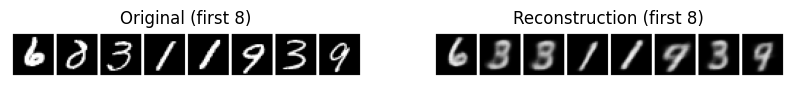

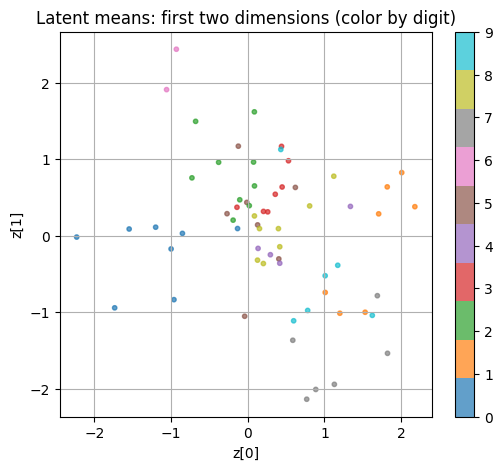

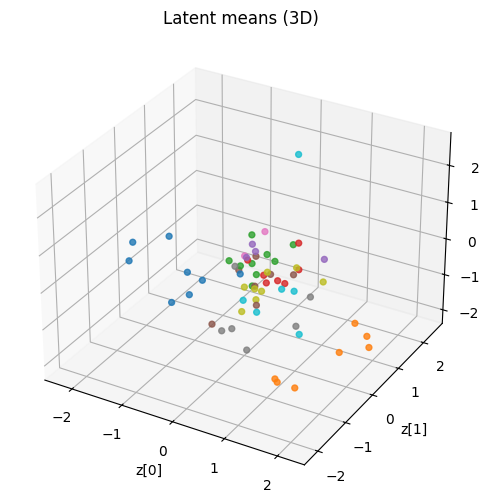

In [6]:
# Python cell: show reconstructions and latent scatter (2D & 3D)
vae.eval()
with torch.no_grad():
    imgs, lbls = next(iter(trainloader))
    imgs = imgs.to(device)[:64]
    x_recon, mu, logvar, z, eps, std = vae(imgs)

# show a grid: original / reconstructed side-by-side
n = 8
orig = (imgs[:n].cpu()*0.5 + 0.5)
recon = (x_recon[:n].cpu()*0.5 + 0.5)
grid_orig = vutils.make_grid(orig, nrow=n, pad_value=1)
grid_recon = vutils.make_grid(recon, nrow=n, pad_value=1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(grid_orig.permute(1,2,0).squeeze(), cmap='gray'); plt.title("Original (first 8)"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(grid_recon.permute(1,2,0).squeeze(), cmap='gray'); plt.title("Reconstruction (first 8)"); plt.axis('off')
plt.show()

# Latent space 2D scatter (use first two dims)
mu_cpu = mu.cpu().numpy()
lbls = lbls[:mu.shape[0]].cpu().numpy()
plt.figure(figsize=(6,5))
scatter = plt.scatter(mu_cpu[:,0], mu_cpu[:,1], c=lbls, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("Latent means: first two dimensions (color by digit)")
plt.xlabel("z[0]"); plt.ylabel("z[1]")
plt.grid(True)
plt.show()

# Latent space 3D scatter (all 3 dims)
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(mu_cpu[:,0], mu_cpu[:,1], mu_cpu[:,2], c=lbls, cmap='tab10', s=18, alpha=0.8)
ax.set_title("Latent means (3D)")
ax.set_xlabel("z[0]"); ax.set_ylabel("z[1]"); ax.set_zlabel("z[2]")
plt.show()


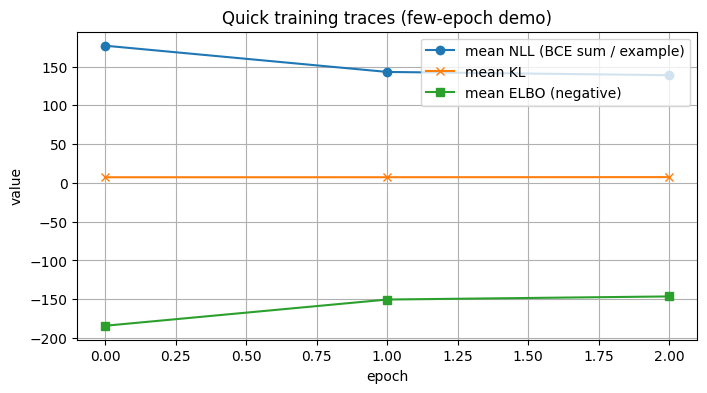

In [7]:
# Python cell: plot training traces
epochs = list(range(len(loss_trace["bce"])))
plt.figure(figsize=(8,4))
plt.plot(epochs, loss_trace["bce"], marker='o', label='mean NLL (BCE sum / example)')
plt.plot(epochs, loss_trace["kl"], marker='x', label='mean KL')
plt.plot(epochs, loss_trace["elbo"], marker='s', label='mean ELBO (negative)')
plt.xlabel('epoch'); plt.ylabel('value'); plt.legend()
plt.title('Quick training traces (few-epoch demo)')
plt.grid(True)
plt.show()


# Summary and mapping code → math

- Encoder outputs $\mu_\phi(x)$ and $\log\sigma_\phi^2(x)$ (`mu` and `logvar` in code).
- Reparameterization: $z=\mu+\sigma\odot\epsilon$ implemented as `z = mu + std * eps`. We printed `eps`, `std`, and `z` to show the stochastic path.
- Reconstruction log-likelihood approximated via BCE on pixel probabilities (we computed per-example BCE).
- KL term computed in closed-form: `kl_per_example = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))`.
- ELBO per example: `ELBO = - (NLL + KL)` (sign convention in code: minimizing `NLL + KL`).
- Visualizations: reconstructions (compare original vs re-decoded), latent 2D and 3D scatter show structure in the latent space.

This notebook demonstrates both **theoretical derivation** and **practical computation** (with printed intermediate values) along with many visual aids.


# Final notes & next steps you can try

- Increase `latent_dim` and add a timestep conditioning network (for VAEs with temporal priors).
- Replace Bernoulli/BCE decoder with Gaussian decoder if you model continuous pixels.
- For deeper understanding, implement analytic gradient checks for the reparameterized estimator versus score-function estimator (REINFORCE) — you will see reparameterization yields much lower variance.
- If you want, I can produce a single `.ipynb` file that contains all these cells ready-to-run, or extend the notebook to:
   - train longer for higher-quality reconstructions,
   - show per-class latent-mean barycenters,
   - implement importance-weighted ELBO (IWAE) and show difference.
